In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import datasets
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import h5py
import csv

> PROYECTO A

In [ ]:
dataset_train = h5py.File('train_a.h5', 'r')
dataset_test = h5py.File('test_a.h5', 'r')
print(f"Keys:  {list(dataset_train.keys())}")
print(f"Keys:  {list(dataset_test.keys())}")
#Heap in one dataset
x_train_dataset_org = np.hstack((dataset_train["body_acc_x"][:],
                     dataset_train["body_acc_y"][:],
                     dataset_train["body_acc_z"][:],

                     dataset_train["body_gyro_x"][:],
                     dataset_train["body_gyro_y"][:],
                     dataset_train["body_gyro_z"][:],

                     dataset_train["total_acc_x"][:],
                     dataset_train["total_acc_y"][:],
                     dataset_train["total_acc_z"][:]
                    ))


x_test_dataset_org = np.hstack((dataset_test["body_acc_x"][:],
                     dataset_test["body_acc_y"][:],
                     dataset_test["body_acc_z"][:],

                     dataset_test["body_gyro_x"][:],
                     dataset_test["body_gyro_y"][:],
                     dataset_test["body_gyro_z"][:],

                     dataset_test["total_acc_x"][:],
                     dataset_test["total_acc_y"][:],
                     dataset_test["total_acc_z"][:]
                    ))


y_train_dataset_org = dataset_train["y"][:]

print(x_train_dataset_org.shape, type(x_train_dataset_org))
print(y_train_dataset_org.shape)

Keys:  ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y']
Keys:  ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']
(7352, 1152) <class 'numpy.ndarray'>
(7352,)


In [ ]:
#KNN model

def PCA_transform(data, n_components):
    mean = np.mean(data, axis=0)
    data_mean = data - mean
    covariance = np.cov(data_mean.T)
    covarinace = np.round(covariance,2)

    eig_val_total, eig_vec_total = np.linalg.eig(covarinace)
    eig_vec =  eig_vec_total[:, :n_components]
    return np.dot(data_mean, eig_vec),  eig_vec, mean

def extend_PCA(x_value, mean, eig_vec):
    return np.dot((x_value - mean), eig_vec)

def PCA_reconstruction(pca_data, eig_vec, mean):
    return np.matmul(pca_data, eig_vec.T) + mean

def evaluation_dims_PCA(dataset_x):
    results = list()
    cases = [1,2,5,10,15,20,30,40,50,100,200]
    for i in cases:
        pca_data, eig_vec, mean = PCA_transform(dataset_x,i)
        data_reconstruida = PCA_reconstruction(pca_data, eig_vec, mean)
        results.append(100 - round(100*np.mean(np.square(dataset_x - data_reconstruida)),4))
        print(f"Usando {i} componentes reconstruimos con: {100 - round(100*np.mean(np.square(dataset_x - data_reconstruida)),4)}")
    return cases, results


def SVD_transform(data, n_components):
    U, Sigma, V = np.linalg.svd(data, full_matrices=False)

    U_reduced = U[:, :n_components]
    sigma_reduced = np.diag(Sigma[:n_components])
    V_reduced = V[:n_components, :]

    return np.dot(U_reduced, sigma_reduced), n_components, V,V_reduced

def extend_SVD(x_value, n_components, V):
    return np.dot(np.array(x_value).reshape(1, -1), V[:n_components, :].T)

def SVD_reconstruction(svd_data, V_reduced):
    return np.dot(svd_data, V_reduced)

def evaluation_dims_SVD(dataset_x):
    results = list()
    cases = [1,2,5,10,15,20,30,40,50,100,200]
    for i in cases:
        svd_data, n_components, V, V_reduced = SVD_transform(dataset_x,i)
        data_reconstruida = SVD_reconstruction(svd_data, V_reduced)
        results.append(100 - round(100*np.mean(np.square(dataset_x - data_reconstruida)),4))
        print(f"Usando {i} componentes reconstruimos con: {100 - round(100*np.mean(np.square(dataset_x - data_reconstruida)),4)}")
    return cases, results



def pick_random_x(data):
    rand_num = random.randint(0, data.shape[0])
    return data[rand_num],rand_num

def calculate_metrics_KNNmodel(y_data, x_data, neigh, mean, eig_vec):
    count=0
    for element in range(x_data.shape[0]):
        x_test = extend_PCA(x_data[element], mean, eig_vec)
        if (neigh.predict([x_test])[0]  == y_data[element]):
            count+=1

    accuracy = count/x_data.shape[0] * 100
    return accuracy
def show_metrics(y_true, y_pred):
    matrix_confu = confusion_matrix(y_true, y_pred)
    print("Matriz de Confusión:")
    print(matrix_confu)

    accuracy = accuracy_score(y_true, y_pred)
    print("\nExactitud (Accuracy):")
    print(accuracy)

    f1 = f1_score(y_true, y_pred, average=None)
    print("\nF1-Score por clase:",f1)

    # Calcular el F1-score promedio (macro)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    print("\nF1-Score promedio (Macro):")
    print(f1_macro)

    # Calcular el F1-score promedio (weighted)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print("\nF1-Score promedio (Weighted):")
    print(f1_weighted)

In [ ]:
#DECISSION TREE
class feature_node:
    def __init__(self, info_gain, feature_name, feature_index):
        self.info_gain = info_gain
        self.gini = 0
        self.feature_name = feature_name
        self.feature_index = feature_index
        self.dict_of_values = dict()

    def get_info_gain(self):
        return self.info_gain
    def get_gini(self):
        return self.gini
    def get_feature_name(self):
        return self.feature_name
    def get_feature_index(self):
        return self.feature_index
    def get_dict_of_values(self):
        return self.dict_of_values

    def create_value_node(self, key, value):
        self.dict_of_values[key] = value

class decission_tree:
    def __init__(self):
        self.nodes = list()

    def calculate_entropy(self, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        proba = counts / len(labels)
        entropy = np.sum(-proba * np.log2(proba))
        return entropy

    def calculate_information_gain(self, df, attribute):
        unique_values = df[attribute].unique()
        entropy_accumulative = 0
        for value in unique_values:
            subset = df[df[attribute] == value]
            entropy_subset = self.calculate_entropy(subset["Y"])
            weight = len(subset) / len(df)
            entropy_accumulative += weight * entropy_subset
        information_gain = self.calculate_entropy(df["Y"]) - entropy_accumulative
        return information_gain


    def elementos_unicos(self, X, Y, length_subset):
        elementos_claros = dict()
        for fila in X:
            subconjunto = tuple(fila[:length_subset])
            if (subconjunto not in elementos_claros):
                indices = np.all(X[:, :length_subset] == subconjunto, axis=1)
                valores_correspondientes_Y = Y[indices]

                if len(np.unique(valores_correspondientes_Y)) == 1:
                    elementos_claros[subconjunto] = tuple(([i for i, valor in enumerate(indices) if valor], np.unique(valores_correspondientes_Y)[0]))
        return elementos_claros

    def train(self,data, Y, criteria):
        self.data = data.reset_index(drop=True)
        self.Y = Y.reset_index(drop=True)

        #Calculamos entropia o Gini
        if criteria == "entrophy":
            data_merge = pd.concat([self.data, self.Y], axis=1)
            for count, feature in enumerate(self.data.columns):
                info_gain = self.calculate_information_gain(data_merge, feature)
                if len(self.nodes) == 0:
                    self.nodes.append(feature_node(info_gain, feature, count))
                else:
                    idx = 0
                    while (self.nodes[idx].get_info_gain() > info_gain):
                        idx+=1
                        if(idx == len(self.nodes)):break
                    self.nodes.insert(idx, feature_node(info_gain, feature, count))
        elif (criteria == "gini"):
            pass


        #Ordenar self.data de acuerdo al criterio
        self.actual_positions = [node.get_feature_index() for node in self.nodes]
        new_positions = [i for i in range(self.data.shape[1])]
        self.data = self.data.iloc[:, self.actual_positions]
        self.data = self.data.iloc[:, new_positions]

        #Creamos el arbol
        for count,node in enumerate(self.nodes):
            #print(f"node name: {node.get_feature_name()} working with: {self.data.shape} and {self.Y.shape}")
            if(self.data.shape[0] != 0):
                decided_elements = self.elementos_unicos(self.data.to_numpy(),
                                                    self.Y.to_numpy(),
                                                    count+1)
                #print(f"Unique elements:  ", decided_elements.keys())
                #print(f"Total: {len(decided_elements.keys())}")

                trash_list = list()
                for element in decided_elements.keys():
                    #print(f"Analizing  {element} is '{decided_elements[element][1]}' and delete this {decided_elements[element][0]}")
                    node.create_value_node(element,decided_elements[element][1])
                    trash_list = trash_list + decided_elements[element][0]
                #print(f"Trash list: {len(trash_list)}")

                self.data = self.data.drop(trash_list)
                self.Y = self.Y.drop(trash_list)
                self.data =self.data.reset_index(drop=True)
                self.Y = self.Y.reset_index(drop=True)

    def show_nodes(self):
        for count, feature in enumerate(self.data.columns):
            print(self.nodes[count].get_feature_name(), f"   {self.nodes[count].get_feature_index()}   ",self.nodes[count].get_info_gain())

    def cambiar_orden_lista(self, lista, posiciones_originales, posiciones_deseadas):
        mapeo_posiciones = dict(zip(posiciones_originales, posiciones_deseadas))
        lista_reordenada = [None] * len(lista)
        for pos_orig, pos_deseada in mapeo_posiciones.items():
            lista_reordenada[pos_deseada] = lista[pos_orig]

        return lista_reordenada


    def predict(self, x_predict):
        #ordenar los datos
        x_predict = self.cambiar_orden_lista(x_predict, self.actual_positions, [i for i in range(self.data.shape[1]) ])

        for count,node in enumerate(self.nodes):
            #print(f"{x_predict[:count+1]}  compared with  {node.get_dict_of_values()} ")
            if (tuple(x_predict[:count+1]) in node.get_dict_of_values()):
                return node.get_dict_of_values()[tuple(x_predict[:count+1])]
            break
        return "UNDECIDED"


class decission_forest:
    def __init__(self,decission_tree_size):
        self.decission_tree_size = decission_tree_size
        self.trees = list()

    def train_forest_random(self, data_x, data_y, number_of_trees):
        self.number_of_trees = number_of_trees
        for tree in range(self.number_of_trees):
            dtree = decission_tree()
            random_indexes = [random.randint(0, data_x.shape[0]-1) for i in range(self.decission_tree_size)]

            dtree.train(data_x.loc[random_indexes][[f"Columna {i+1}" for i in range(data_x.shape[1])]],
                        data_y.loc[random_indexes][["Y"]],
                        criteria="entrophy")
            self.trees.append(dtree)

            print(f"Indices de entrenamiento:  {random_indexes}")

        print("Training process completed!")

    def train_forest_complete(self, data_x, data_y):
        for i in range(data_x.shape[0] // self.decission_tree_size):
            indexes = [m for m in range(i*self.decission_tree_size, (i+1)*self.decission_tree_size)]
            dtree = decission_tree()
            dtree.train(data_x.loc[indexes][[f"Columna {i+1}" for i in range(data_x.shape[1])]],
                        data_y.loc[indexes][["Y"]],
                        criteria="entrophy")
            self.trees.append(dtree)
            print(f" {i}", end=" ")

        print("Training process completed!")


    def prediction_forest(self, x_test):
        predictions = [dtress.predict(x_test) for dtress in self.trees ]
        contador = Counter(predictions)
        if "UNDECIDED" in contador:
            del contador["UNDECIDED"]
        try:return contador.most_common(1)[0][0]
        except IndexError:return -1


**DECISSION TREE ANALYSIS:**

In [ ]:
#Preparacion de los datos (particion)
column_names = [f"Columna {i+1}" for i in range(1152)]
x_train_dataset = pd.DataFrame(x_train_dataset_org, columns=column_names)
y_train_dataset = pd.DataFrame({"Y": y_train_dataset_org})
X_train, X_test, y_train, y_test = train_test_split(x_train_dataset, y_train_dataset, test_size=0.1, random_state=42)
X_train = X_train.reset_index(drop=True).round(3)
X_test = X_test.reset_index(drop=True).round(3)
y_train = y_train.reset_index(drop=True).round(3)
y_test = y_test.reset_index(drop=True).round(3)

In [ ]:
#Entrenamiento con train_forest_random
dforest_r = decission_forest(150)

dforest_r.train_forest_random(x_train_dataset, y_train_dataset, number_of_trees = 100)

Indices de entrenamiento:  [3908, 5413, 6748, 570, 5343, 2429, 6813, 6119, 4476, 6416, 3543, 261, 3206, 3697, 5043, 2757, 89, 2488, 6348, 202, 5366, 554, 5750, 5804, 1564, 3237, 103, 4388, 5078, 6361, 6971, 881, 3388, 5400, 2644, 6733, 6457, 6504, 3109, 3424, 1307, 1411, 6321, 4176, 727, 2158, 4779, 1027, 6469, 797, 3173, 4061, 5985, 3402, 1992, 1734, 4658, 1387, 2135, 7189, 772, 1817, 169, 414, 6177, 1962, 1046, 7188, 6615, 5794, 2573, 5647, 6159, 4056, 5055, 3887, 4528, 3191, 1605, 3775, 6253, 1533, 272, 4434, 2965, 4200, 2064, 7102, 3675, 4556, 2856, 3616, 2861, 6360, 2088, 3584, 1362, 4484, 772, 4824, 4041, 4238, 310, 2951, 3612, 1658, 5255, 3048, 4414, 6559, 2068, 6285, 222, 2092, 7285, 7025, 2962, 5980, 4802, 317, 1770, 719, 5481, 4791, 1156, 734, 6537, 701, 2062, 3765, 6730, 6720, 4012, 5183, 4030, 7314, 216, 4376, 513, 3429, 2074, 2884, 86, 4179, 3149, 1021, 424, 3669, 1335, 1463]
Indices de entrenamiento:  [3905, 3892, 3546, 4968, 4732, 3936, 3833, 6076, 3725, 6733, 7257, 906,

In [ ]:
#Entrenamiento con train_forest_complete
dforest_c = decission_forest(120)
dforest_c.train_forest_complete(X_train,y_train)

 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54 Training process completed!


In [ ]:
y_predict = list()
for elem in range(X_train.shape[0]):
    aux = dforest_r.prediction_forest(np.array(X_train.loc[elem]))
    y_predict.append(aux)

y_predict = [-1 if valor is None else valor for valor in y_predict]
print("Datos predichos:  ", y_predict)
print("Datos reales:  "   , y_train['Y'].tolist())
show_metrics(y_train['Y'].tolist() , y_predict)

Datos predichos:   [1.0, 1.0, 5.0, 2.0, 5.0, 6.0, 2.0, 3.0, 2.0, 2.0, 1.0, 5.0, 6.0, 3.0, 3.0, 2.0, 4.0, 4.0, 2.0, 1.0, 4.0, 1.0, 6.0, 6.0, 1.0, 1.0, 6.0, 3.0, 5.0, 5.0, 6.0, 5.0, 1.0, 2.0, 2.0, 4.0, 4.0, 2.0, 3.0, 6.0, 2.0, 1.0, 1.0, 6.0, 1.0, 3.0, 3.0, 3.0, 2.0, 3.0, 5.0, 1.0, 4.0, 3.0, 1.0, 6.0, 6.0, 3.0, 5.0, 6.0, 6.0, 6.0, 4.0, 4.0, 5.0, 2.0, 5.0, 5.0, 1.0, 6.0, 1.0, 1.0, 4.0, 5.0, 3.0, 3.0, 2.0, 5.0, 5.0, 2.0, 2.0, 4.0, 6.0, 4.0, 6.0, 3.0, 1.0, 1.0, 3.0, 5.0, 4.0, 4.0, 5.0, 3.0, 6.0, 5.0, 3.0, 1.0, 4.0, 6.0, 5.0, 4.0, 5.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 6.0, 5.0, 4.0, 3.0, 2.0, 6.0, 2.0, 2.0, 6.0, 3.0, 6.0, 6.0, 4.0, 4.0, 2.0, 5.0, 4.0, 4.0, 4.0, 2.0, 3.0, 5.0, 6.0, 6.0, 2.0, 4.0, 6.0, 5.0, 6.0, 4.0, 3.0, 6.0, 1.0, 1.0, 2.0, 5.0, 4.0, 5.0, 3.0, 3.0, 6.0, 5.0, 6.0, 5.0, 1.0, 1.0, 3.0, 4.0, 6.0, 3.0, 4.0, 4.0, 6.0, 4.0, 6.0, 5.0, 2.0, 5.0, 6.0, 1.0, 1.0, 4.0, 2.0, 5.0, 5.0, 1.0, 5.0, 3.0, 2.0, 1.0, 3.0, 1.0, 2.0, 6.0, 5.0, 5.0, 5.0, 5.0, 6.0, 2.0, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 

In [ ]:
y_predict = list()
for elem in range(X_test.shape[0]):
    aux = dforest_r.prediction_forest(np.array(X_test.loc[elem]))
    y_predict.append(aux)

y_predict = [-1 if valor is None else valor for valor in y_predict]
print("Datos predichos:  ", y_predict)
print("Datos reales:  "   , y_test['Y'].tolist())
show_metrics(y_test['Y'].tolist(), y_predict)

Datos predichos:   [3.0, 5.0, -1, 2.0, 3.0, 4.0, -1, 5.0, 3.0, -1, -1, 5.0, -1, 5.0, -1, -1, 6.0, -1, -1, 1.0, -1, 5.0, 5.0, 6.0, 5.0, -1, -1, -1, 5.0, 5.0, 2.0, -1, 5.0, -1, 4.0, 4.0, 3.0, 2.0, -1, 3.0, -1, -1, 3.0, -1, 1.0, -1, -1, 5.0, -1, -1, -1, -1, 2.0, -1, -1, -1, -1, 2.0, 2.0, 6.0, -1, 6.0, -1, -1, -1, -1, 5.0, 3.0, -1, -1, 2.0, 2.0, 4.0, -1, 4.0, 4.0, -1, -1, 4.0, 5.0, -1, 5.0, -1, 6.0, 4.0, 3.0, 2.0, -1, 4.0, -1, -1, 6.0, -1, -1, 5.0, -1, 2.0, 4.0, -1, 1.0, -1, 5.0, -1, -1, -1, -1, 6.0, -1, 1.0, -1, -1, -1, -1, -1, -1, 5.0, -1, 6.0, -1, -1, -1, 5.0, -1, -1, 5.0, 1.0, -1, 5.0, -1, -1, 1.0, 1.0, -1, 4.0, 4.0, 2.0, 1.0, -1, -1, 1.0, -1, -1, -1, 4.0, 6.0, 1.0, 2.0, 3.0, 1.0, -1, 2.0, 6.0, -1, -1, -1, -1, 1.0, 3.0, -1, -1, -1, -1, 5.0, 3.0, 4.0, -1, -1, -1, -1, 3.0, -1, -1, 3.0, 5.0, -1, -1, -1, -1, -1, -1, -1, 5.0, -1, -1, -1, -1, -1, -1, -1, 4.0, 3.0, 3.0, -1, -1, 4.0, 4.0, -1, -1, 4.0, -1, -1, -1, -1, -1, -1, 2.0, 5.0, 6.0, 6.0, 5.0, 2.0, 5.0, 3.0, -1, 5.0, 4.0, 2.0, -1, 2.0, 3

**KNN ANALYSIS:**

In [ ]:
#PCA
cases, error_average = evaluation_dims_PCA(dataset_x=x_train_dataset_org)

Usando 1 componentes reconstruimos con: 93.58670000000001
Usando 2 componentes reconstruimos con: 94.1063
Usando 5 componentes reconstruimos con: 95.1861
Usando 10 componentes reconstruimos con: 96.3206
Usando 15 componentes reconstruimos con: 96.904
Usando 20 componentes reconstruimos con: 97.2465
Usando 30 componentes reconstruimos con: 97.6275
Usando 40 componentes reconstruimos con: 97.8333
Usando 50 componentes reconstruimos con: 98.0556
Usando 100 componentes reconstruimos con: 98.8057
Usando 200 componentes reconstruimos con: 99.2867


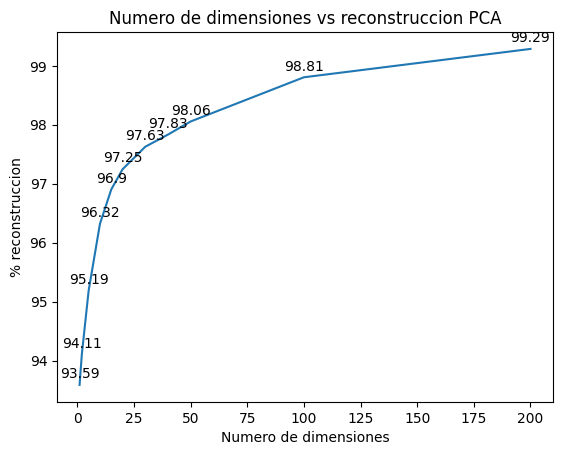

In [ ]:
plt.plot(cases, error_average)
plt.title("Numero de dimensiones vs reconstruccion PCA")
plt.xlabel("Numero de dimensiones")
plt.ylabel("% reconstruccion")
for i, txt in enumerate(error_average):
    plt.annotate(f'{round(txt,2)}', (cases[i], error_average[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.show()

In [ ]:
#SVD
cases, error_average = evaluation_dims_SVD(dataset_x=x_train_dataset_org)

Usando 1 componentes reconstruimos con: 91.6067
Usando 2 componentes reconstruimos con: 93.9466
Usando 5 componentes reconstruimos con: 95.17830000000001
Usando 10 componentes reconstruimos con: 96.3403
Usando 15 componentes reconstruimos con: 96.9342
Usando 20 componentes reconstruimos con: 97.295
Usando 30 componentes reconstruimos con: 97.7432
Usando 40 componentes reconstruimos con: 98.0673
Usando 50 componentes reconstruimos con: 98.3366
Usando 100 componentes reconstruimos con: 99.209
Usando 200 componentes reconstruimos con: 99.7898


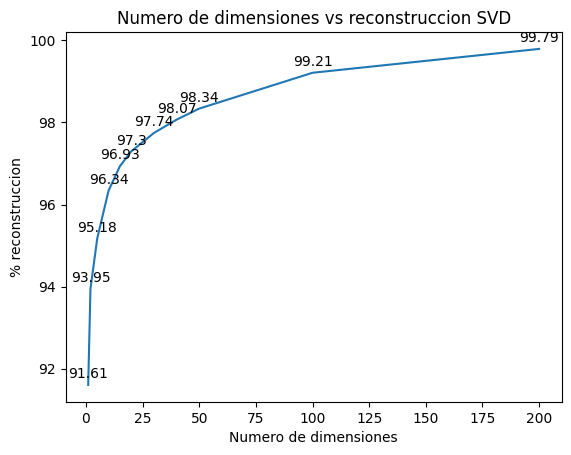

In [ ]:
plt.plot(cases, error_average)
plt.title("Numero de dimensiones vs reconstruccion SVD")
plt.xlabel("Numero de dimensiones")
plt.ylabel("% reconstruccion")
for i, txt in enumerate(error_average):
    plt.annotate(f'{round(txt,2)}', (cases[i], error_average[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.show()

In [ ]:
n_neighbors  = 4
n_components = 40

X_train, X_test, y_train, y_test = train_test_split(x_train_dataset_org, y_train_dataset_org, test_size=0.2, random_state=42)

pca_data, eig_vec, mean = PCA_transform(x_train_dataset_org, n_components)
neigh = KNeighborsClassifier(n_neighbors)
neigh.fit(pca_data, y_train_dataset_org)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
x_train_test, index = pick_random_x(x_train_dataset_org)
x_train_test = extend_PCA(x_train_test, mean, eig_vec)
print(f"Prueba:  {x_train_test}:    {neigh.predict([x_train_test])}  real:  {y_train_dataset_org[index]}")

accuracy = calculate_metrics_KNNmodel(y_train_dataset_org, x_train_dataset_org, neigh, mean, eig_vec)
print("KNN accuracy: ",accuracy)

Prueba:  [ 9.66122438e-01 -5.29240190e-01  2.86469265e-01 -1.18881993e+00
 -2.52668478e-01  1.81413630e+00  6.61543156e-05 -6.50819930e-02
 -5.30262509e-02  1.49074851e-01 -3.78855569e-02  1.81464408e-02
 -3.85867409e-02  4.57570438e-02 -1.71321025e-02  1.22457047e-02
  3.45067526e-02  2.12693376e-02 -8.12958064e-03  7.52837692e-03
 -2.68874924e-02 -1.87788431e-02 -3.35964309e-02  2.57443252e-02
  1.87594140e-02 -5.14719648e-03  1.82411890e-03 -5.13827375e-02
 -5.87704288e-02 -2.69792919e-02 -1.40185367e-02 -2.57591505e-03
  1.23794154e-02 -1.62876585e-02  2.09733244e-03  7.03465849e-04
 -9.30971085e-03 -4.04883593e-03 -1.81653363e-03 -2.15059033e-03]:    [4.]  real:  4.0
KNN accuracy:  97.41566920565833


In [ ]:

y_predict = list()
for each in range(X_test.shape[0]):
    y_predict.append(neigh.predict([extend_PCA(X_test[each], mean, eig_vec)]))

show_metrics(y_predict, y_test)

Matriz de Confusión:
[[245   2   8   0   0   0]
 [  1 194   4   0   0   0]
 [  0   0 188   0   0   0]
 [  0   1   1 259  16   0]
 [  1   3   5   3 260   0]
 [  0   0   0   0   0 280]]

Exactitud (Accuracy):
0.9694085656016316

F1-Score por clase: [0.97609562 0.97243108 0.95431472 0.96103896 0.94890511 1.        ]

F1-Score promedio (Macro):
0.9687975810940519

F1-Score promedio (Weighted):
0.9695032742574962


In [ ]:
#PCA Testing
accura = list()
for compone in [5,10,20,40,100]:
    for neighboo in [3,5,7,9]:
        n_neighbors  = neighboo
        n_components = compone

        X_train, X_test, y_train, y_test = train_test_split(x_train_dataset_org, y_train_dataset_org, test_size=0.2, random_state=42)

        pca_data, eig_vec, mean = PCA_transform(x_train_dataset_org, n_components)
        neigh = KNeighborsClassifier(n_neighbors)
        neigh.fit(pca_data, y_train_dataset_org)

        y_predict = list()
        for each in range(X_test.shape[0]):
            y_predict.append(neigh.predict([extend_PCA(X_test[each], mean, eig_vec)]))

        accuracy = accuracy_score(y_test, y_predict)
        print("\nExactitud (Accuracy): ",accuracy)
        accura.append(accuracy)


Exactitud (Accuracy):  0.9191026512576479

Exactitud (Accuracy):  0.9000679809653297

Exactitud (Accuracy):  0.8871515975526852

Exactitud (Accuracy):  0.8769544527532291

Exactitud (Accuracy):  0.9707681849082257

Exactitud (Accuracy):  0.9585316111488783

Exactitud (Accuracy):  0.9524133242692047

Exactitud (Accuracy):  0.9415363698164514

Exactitud (Accuracy):  0.9802855200543847

Exactitud (Accuracy):  0.9707681849082257

Exactitud (Accuracy):  0.9605710401087696

Exactitud (Accuracy):  0.9598912304554724

Exactitud (Accuracy):  0.9782460910944936

Exactitud (Accuracy):  0.9694085656016316

Exactitud (Accuracy):  0.9619306594153637

Exactitud (Accuracy):  0.9537729435757988

Exactitud (Accuracy):  0.9660095173351462

Exactitud (Accuracy):  0.9449354180829368

Exactitud (Accuracy):  0.9320190346702923

Exactitud (Accuracy):  0.9150237933378654


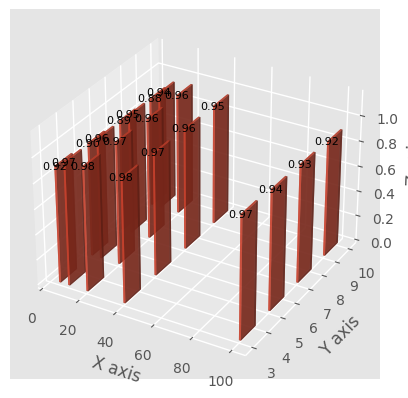

In [ ]:
style.use('ggplot')

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

#creating the dataset
5,10,20,40,100
3,5,7,9
x3 = [5,5,5,5,10,10,10,10,20,20,20,20,40,40,40,40,100,100,100,100]
y3 = [3,5,7,9,3,5,7,9,3,5,7,9,3,5,7,9,3,5,7,9]
z3 = np.zeros(20)
dx = np.ones(20)
dy = np.ones(20)
dz = accura
#plotting the 3D bar graph

bars = ax1.bar3d(x3, y3, z3, dx, dy, dz, alpha=0.7)

for x, y, z in zip(x3, y3, dz):
    ax1.text(x, y, z, '%.2f' % z, ha='center', va='center', fontsize=8)

ax1.set_zlim(0, max(accura) * 1.2)
ax1.set_xlim(min(x3) - 5, max(x3) + 5)
# labeling the axes
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')

plt.show()

In [ ]:
#SVD Testing
accura2 = list()
for compone in [5,10,20,40,100]:
    for neighboo in [3,5,7,9]:
        n_neighbors  = neighboo
        n_components = compone

        X_train, X_test, y_train, y_test = train_test_split(x_train_dataset_org, y_train_dataset_org, test_size=0.2, random_state=42)

        svd_data,  n_components, V,V_reduced = SVD_transform(x_train_dataset_org, n_components)
        neigh = KNeighborsClassifier(n_neighbors)
        neigh.fit(svd_data, y_train_dataset_org)
        #print(svd_data.shape)

        y_predict = list()
        for each in range(X_test.shape[0]):
            #print(extend_SVD(X_test[each], n_components, V))
            y_predict.append(neigh.predict(extend_SVD(X_test[each], n_components, V)))

        accuracy = accuracy_score(y_test, y_predict)
        print("\nExactitud (Accuracy): ",accuracy)
        accura2.append(accuracy)


Exactitud (Accuracy):  0.9184228416043508

Exactitud (Accuracy):  0.8973487423521413

Exactitud (Accuracy):  0.8966689326988443

Exactitud (Accuracy):  0.8885112168592794

Exactitud (Accuracy):  0.9660095173351462

Exactitud (Accuracy):  0.9578518014955812

Exactitud (Accuracy):  0.947654656696125

Exactitud (Accuracy):  0.9408565601631543

Exactitud (Accuracy):  0.9782460910944936

Exactitud (Accuracy):  0.972807613868117

Exactitud (Accuracy):  0.9632902787219578

Exactitud (Accuracy):  0.9605710401087696

Exactitud (Accuracy):  0.9748470428280082

Exactitud (Accuracy):  0.9639700883752549

Exactitud (Accuracy):  0.9537729435757988

Exactitud (Accuracy):  0.9490142760027193

Exactitud (Accuracy):  0.9626104690686608

Exactitud (Accuracy):  0.9354180829367778

Exactitud (Accuracy):  0.9177430319510537

Exactitud (Accuracy):  0.902787219578518


>**SUBMISSION:**

In [ ]:
y_predict = list()
for each in range(x_test_dataset_org.shape[0]):
    y_predict.append(neigh.predict([extend_PCA(x_test_dataset_org[each], mean, eig_vec)])[0])

print(y_predict)
supermatriz_x = np.concatenate((x_train_dataset_org, x_test_dataset_org), axis=0)
supermatriz_y = np.concatenate((y_train_dataset_org, y_predict), axis=0)


[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 5.0, 4.0, 5.0, 1.0, 3.0, 3.0, 2.0, 2.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0,

In [ ]:
print(supermatriz_x.shape)
print(supermatriz_y.shape)
print(x_test_dataset_org.shape)
print(x_train_dataset_org.shape)

(10299, 1152)
(10299,)
(2947, 1152)
(7352, 1152)


In [ ]:
n_neighbors  = 5
n_components = 30

pca_data, eig_vec, mean = PCA_transform(supermatriz_x, n_components)
neigh = KNeighborsClassifier(n_neighbors)

neigh.fit(pca_data, supermatriz_y)

KNeighborsClassifier()

In [ ]:
y_predictt = list()
for each in range(x_test_dataset_org.shape[0]):
    y_predictt.append(neigh.predict([extend_PCA(x_test_dataset_org[each], mean, eig_vec)])[0])

print(y_predictt)

[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 5.0, 5.0, 4.0, 5.0, 3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0,

In [ ]:
with open("predicciones6.csv", "w", newline="") as archivo_csv:
    writer = csv.writer(archivo_csv)
    writer.writerow(["ID", "Predicción"])

    for i, prediccion in enumerate(y_predictt, start=1):
        writer.writerow([i, prediccion])

print("Archivo CSV creado")

Archivo CSV creado


In [ ]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())



In [ ]:



y_predict = list()
for elem in range(X_test.shape[0]):
    aux = clf.predict([np.array(X_test.loc[elem])])
    y_predict.append(aux)

y_predict = [-1 if valor is None else valor for valor in y_predict]
print("Datos predichos:  ", y_predict)
print("Datos reales:  "   , y_test['Y'].tolist())
show_metrics(y_test['Y'].tolist(), y_predict)

Datos predichos:   [array([3.]), array([3.]), array([1.]), array([4.]), array([3.]), array([3.]), array([2.]), array([1.]), array([3.]), array([5.]), array([6.]), array([1.]), array([2.]), array([1.]), array([5.]), array([1.]), array([6.]), array([2.]), array([2.]), array([2.]), array([6.]), array([3.]), array([5.]), array([6.]), array([1.]), array([5.]), array([1.]), array([1.]), array([2.]), array([1.]), array([3.]), array([6.]), array([2.]), array([2.]), array([2.]), array([4.]), array([6.]), array([5.]), array([6.]), array([5.]), array([6.]), array([2.]), array([1.]), array([6.]), array([5.]), array([3.]), array([5.]), array([5.]), array([6.]), array([3.]), array([5.]), array([6.]), array([2.]), array([6.]), array([4.]), array([4.]), array([2.]), array([1.]), array([4.]), array([6.]), array([3.]), array([2.]), array([5.]), array([3.]), array([3.]), array([4.]), array([5.]), array([3.]), array([2.]), array([5.]), array([5.]), array([2.]), array([1.]), array([5.]), array([4.]), array